## Predictive Modeling: Individual Task Duration Prediction
### Using Random Forest Regressor to predict how long each individual task will take
#### This model predicts task_duration for Task_1, Task_2, Task_3, and Task_4

In [1]:
# pip install matplotlib scikit-learn seaborn

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load the cleaned data
df = pd.read_csv('Technical_Assistance_Cleaned.csv')

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset loaded: 259 rows, 18 columns

Columns: ['Year', 'Mth', 'Day', 'start_date', 'end_date', 'duration', 'Engine', 'Variant', 'Operator', 'Brief Description of Technical Intervention', 'Task_1', 'Task_2', 'Task_3', 'Task_4', 'task_count', 'task_duration', 'Intervention level', 'By']


,Year,Mth,Day,start_date,end_date,duration,Engine,Variant,Operator,Brief Description of Technical Intervention,Task_1,Task_2,Task_3,Task_4,task_count,task_duration,Intervention level,By
0,2013,MARCH,14,14,14,1,ACCESSORIES,NaN,PT TRAVIRA,HMU,HMU,NaN,NaN,NaN,1,1,L2,BS
1,2013,MARCH,14,14,14,1,ARRIEL 2,2S2,PT TRAVIRA,MODULE 4 & 5 REPLACEMENT,MO4 REPLACEMENT,MO5 REPLACEMENT,NaN,NaN,2,1,L2,BS
2,2013,MARCH,27,27,27,1,ARRIEL 1,1S1,MHS,"TU347,MO5 REPLACEMENT",TU 347,MO5 REPLACEMENT,NaN,NaN,2,1,L3,BS
3,2013,APR,9,9,9,1,ACCESSORIES,2D,PT AIRFAST,HMU SLEEVE REPLACEMENT,HMU SLEEVE REPLACEMENT,NaN,NaN,NaN,1,1,L2,BS
4,2013,MAY,10,10,10,1,ARRIEL 1,1S1,MHS,MODULE 1 REPLACEMENT,MO1 REPLACEMENT,NaN,NaN,NaN,1,1,L2,BS


### 1. Data Reshaping: Unpivot Tasks
#### Transform from wide format (Task_1, Task_2, Task_3, Task_4 as columns) to long format (one row per task)

In [4]:
# Reshape data: create one row for each task
task_rows = []

for idx, row in df.iterrows():
    # Common fields for all tasks in this row
    base_data = {
        'Year': row['Year'],
        'Mth': row['Mth'],
        'Engine': row['Engine'],
        'Variant': row['Variant'],
        'Operator': row['Operator'],
        'Intervention level': row['Intervention level'],
        'By': row['By'],
        # 'Staff': row['Staff'],
        # 'Scheduled/Unscheduled/AOG': row['Scheduled/Unscheduled/AOG'],
        'task_count': row['task_count'],
        'task_duration': row['task_duration'],
        'row_duration': row['duration']  # Original row duration for reference
    }
    
    # Create a row for each non-null task
    for task_num in [1, 2, 3, 4]:
        task_col = f'Task_{task_num}'
        if pd.notna(row[task_col]):
            task_data = base_data.copy()
            task_data['task_name'] = row[task_col]
            task_data['task_position'] = task_num
            task_rows.append(task_data)

# Create new dataframe with one row per task
df_tasks = pd.DataFrame(task_rows)

print(f"Original dataframe: {len(df)} rows")
print(f"Task-level dataframe: {len(df_tasks)} rows (one row per task)")
print(f"\nTask-level dataframe columns: {df_tasks.columns.tolist()}")
print(f"\nSample of reshaped data:")
df_tasks.head(10)

Original dataframe: 259 rows
Task-level dataframe: 283 rows (one row per task)

Task-level dataframe columns: ['Year', 'Mth', 'Engine', 'Variant', 'Operator', 'Intervention level', 'By', 'task_count', 'task_duration', 'row_duration', 'task_name', 'task_position']

Sample of reshaped data:


,Year,Mth,Engine,Variant,Operator,Intervention level,By,task_count,task_duration,row_duration,task_name,task_position
0,2013,MARCH,ACCESSORIES,NaN,PT TRAVIRA,L2,BS,1,1,1,HMU,1
1,2013,MARCH,ARRIEL 2,2S2,PT TRAVIRA,L2,BS,2,1,1,MO4 REPLACEMENT,1
2,2013,MARCH,ARRIEL 2,2S2,PT TRAVIRA,L2,BS,2,1,1,MO5 REPLACEMENT,2
3,2013,MARCH,ARRIEL 1,1S1,MHS,L3,BS,2,1,1,TU 347,1
4,2013,MARCH,ARRIEL 1,1S1,MHS,L3,BS,2,1,1,MO5 REPLACEMENT,2
5,2013,APR,ACCESSORIES,2D,PT AIRFAST,L2,BS,1,1,1,HMU SLEEVE REPLACEMENT,1
6,2013,MAY,ARRIEL 1,1S1,MHS,L2,BS,1,1,1,MO1 REPLACEMENT,1
7,2013,MAY,ARRIEL 1,1S1,MHS,L2,KA,1,1,1,MO5 REPLACEMENT,1
8,2013,MAY,ARRIEL 2,2C2,VNH NORTH,L3,BS,1,1,1,TU 166,1
9,2013,MAY,ARRIEL 2,2C2,VNH NORTH,L3,BS,1,1,1,TU 166,1


### 2. Exploratory Data Analysis (EDA)

In [5]:
df_tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Year                283 non-null    int64 
 1   Mth                 283 non-null    object
 2   Engine              283 non-null    object
 3   Variant             282 non-null    object
 4   Operator            281 non-null    object
 5   Intervention level  283 non-null    object
 6   By                  283 non-null    object
 7   task_count          283 non-null    int64 
 8   task_duration       283 non-null    int64 
 9   row_duration        283 non-null    int64 
 10  task_name           283 non-null    object
 11  task_position       283 non-null    int64 
dtypes: int64(5), object(7)
memory usage: 26.7+ KB


In [6]:
# Check for missing values
print("Missing values in task-level data:")
print(df_tasks.isna().sum())

print(f"\nUnique tasks: {df_tasks['task_name'].nunique()}")
print(f"\nTask distribution:")
print(df_tasks['task_name'].value_counts().head(20))

Missing values in task-level data:
Year                  0
Mth                   0
Engine                0
Variant               1
Operator              2
Intervention level    0
By                    0
task_count            0
task_duration         0
row_duration          0
task_name             0
task_position         0
dtype: int64

Unique tasks: 86

Task distribution:
task_name
MO1 VIBRATION CHECK       66
PIR                       37
KANBAN REPORT             22
MO3 REPLACEMENT            9
MO1 REPLACEMENT            8
MO2 REPLACEMENT            8
TU 347                     6
BORESCOPE INSPECTION       6
MO5 REPLACEMENT            6
MO4 REPLACEMENT            4
HMU INSTALLATION           4
MAG SEAL                   4
ENGINE INSPECTION          4
STANDARD EXCHANGE MO2      4
STANDARD EXCHANGE MO1      3
HMU SLEEVE REPLACEMENT     3
TU 166                     3
MSB 292 72 2861            3
ENGINE ASSESSMENT          3
POST RENTAL INSPECTION     2
Name: count, dtype: int64


In [7]:
df_tasks = df_tasks.dropna()

In [8]:
# Check for missing values
print("Missing values in task-level data:")
print(df_tasks.isna().sum())

Missing values in task-level data:
Year                  0
Mth                   0
Engine                0
Variant               0
Operator              0
Intervention level    0
By                    0
task_count            0
task_duration         0
row_duration          0
task_name             0
task_position         0
dtype: int64


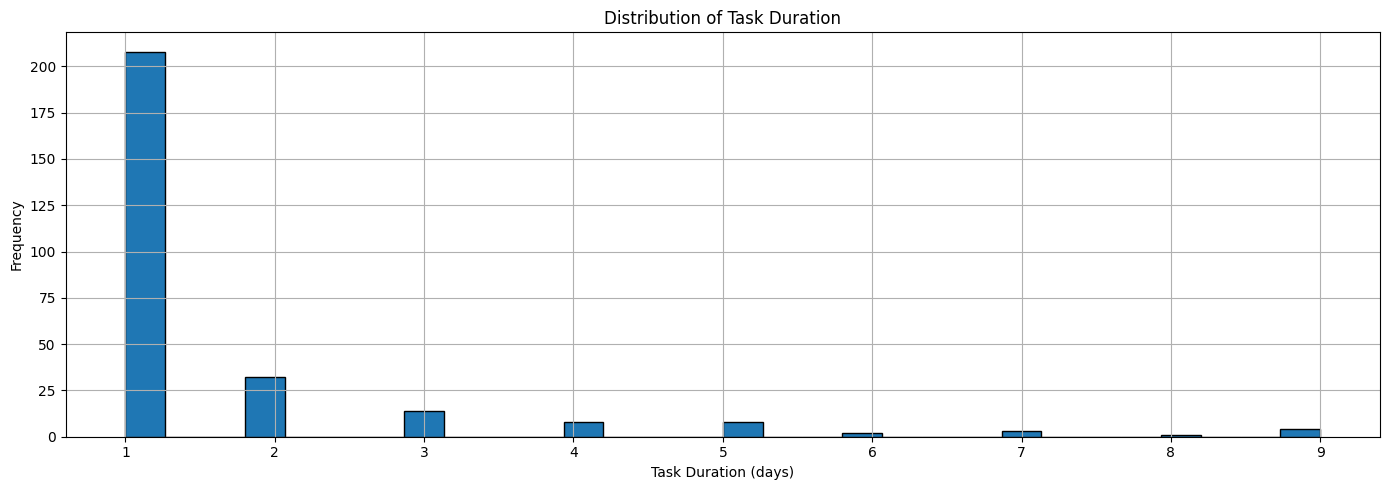


Task Duration Statistics:
count    280.000000
mean       1.653571
std        1.504350
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: task_duration, dtype: float64


In [9]:
# Distribution of task_duration (target variable)
plt.figure(figsize=(14, 5))

df_tasks['task_duration'].hist(bins=30, edgecolor='black')
plt.xlabel('Task Duration (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Task Duration')

plt.tight_layout()
plt.show()

print(f"\nTask Duration Statistics:")
print(df_tasks['task_duration'].describe())

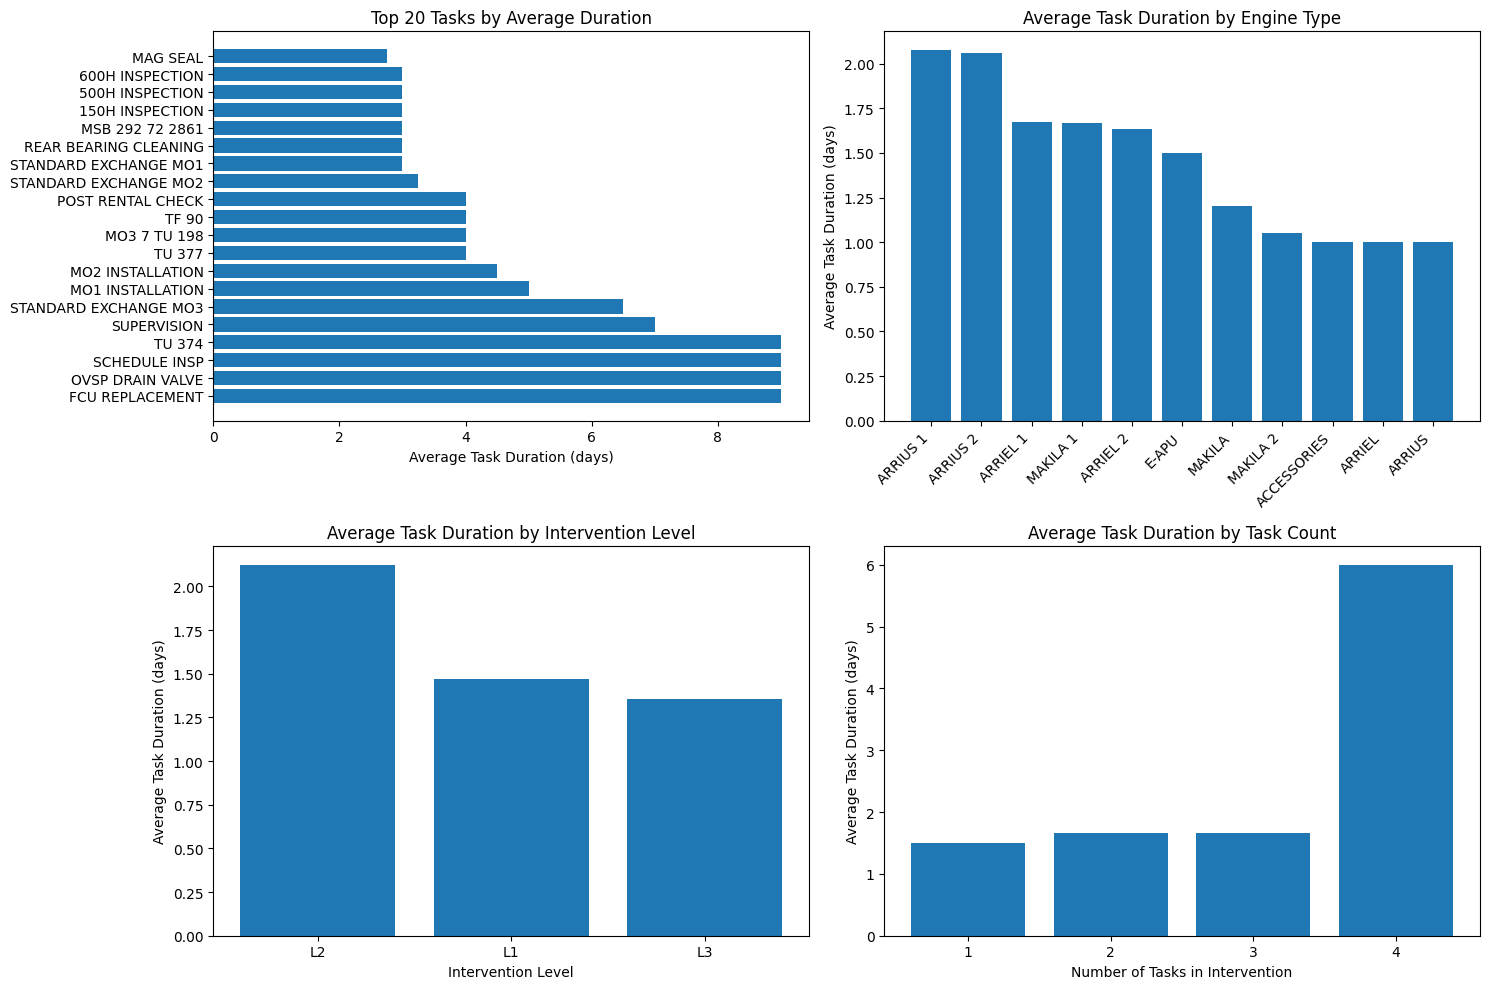

In [10]:
# Analyze task_duration by key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Duration by task_name
task_duration = df_tasks.groupby('task_name')['task_duration'].mean().sort_values(ascending=False).head(20)
axes[0, 0].barh(task_duration.index, task_duration.values)
axes[0, 0].set_xlabel('Average Task Duration (days)')
axes[0, 0].set_title('Top 20 Tasks by Average Duration')

# Duration by Engine
engine_duration = df_tasks.groupby('Engine')['task_duration'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(engine_duration)), engine_duration.values)
axes[0, 1].set_xticks(range(len(engine_duration)))
axes[0, 1].set_xticklabels(engine_duration.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Average Task Duration (days)')
axes[0, 1].set_title('Average Task Duration by Engine Type')

# Duration by Intervention Level
level_duration = df_tasks.groupby('Intervention level')['task_duration'].mean().sort_values(ascending=False)
axes[1, 0].bar(level_duration.index, level_duration.values)
axes[1, 0].set_xlabel('Intervention Level')
axes[1, 0].set_ylabel('Average Task Duration (days)')
axes[1, 0].set_title('Average Task Duration by Intervention Level')

# Duration by task_count (number of tasks in the same intervention)
count_duration = df_tasks.groupby('task_count')['task_duration'].mean().sort_values()
axes[1, 1].bar(count_duration.index.astype(str), count_duration.values)
axes[1, 1].set_xlabel('Number of Tasks in Intervention')
axes[1, 1].set_ylabel('Average Task Duration (days)')
axes[1, 1].set_title('Average Task Duration by Task Count')

plt.tight_layout()
plt.show()

### 3. Feature Engineering

In [11]:
# Create a copy for modeling
df_model = df_tasks.copy()

### 4. Data Preparation for Modeling

In [12]:
# Select features for modeling
feature_cols = [
    'task_name',              # The specific task being performed
    # 'task_position',          # Position in the sequence (1, 2, 3, or 4)
    'Engine',                 # Engine type
    'Variant',                # Engine variant
    'Operator',               # Operator/company
    'Intervention level',     # L1, L2, L3
    'By',                     # Technician
    'task_count',             # Total number of tasks in this intervention
    # 'Year',                   # Year
    # 'month_num',              # Month as number
    # 'quarter'                 # Quarter
]

# Keep only columns that exist in the dataframe
feature_cols = [col for col in feature_cols if col in df_model.columns]

print(f"\nFeatures selected for modeling: {feature_cols}")

# Create feature matrix and target
X = df_model[feature_cols].copy()
y = df_model['task_duration'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Features selected for modeling: ['task_name', 'Engine', 'Variant', 'Operator', 'Intervention level', 'By', 'task_count']

Feature matrix shape: (280, 7)
Target variable shape: (280,)


In [13]:
# Encode categorical variables
label_encoders = {}
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Encoding {len(categorical_cols)} categorical columns...")

for col in categorical_cols:
    le = LabelEncoder()
    # Handle missing values by filling with a placeholder
    X[col] = X[col].fillna('MISSING')
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} unique values")

# Fill any remaining missing values in numeric columns
X = X.fillna(0)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

Encoding 6 categorical columns...
  - task_name: 85 unique values
  - Engine: 11 unique values
  - Variant: 37 unique values
  - Operator: 102 unique values
  - Intervention level: 3 unique values
  - By: 11 unique values

Final feature matrix shape: (280, 7)
Features: ['task_name', 'Engine', 'Variant', 'Operator', 'Intervention level', 'By', 'task_count']


### 5. Train-Test Split

In [14]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nTraining set task_duration stats:")
print(y_train.describe())
print(f"\nTesting set task_duration stats:")
print(y_test.describe())

Training set: 224 samples
Testing set: 56 samples

Training set task_duration stats:
count    224.000000
mean       1.696429
std        1.531957
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: task_duration, dtype: float64

Testing set task_duration stats:
count    56.000000
mean      1.482143
std       1.388146
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       9.000000
Name: task_duration, dtype: float64


### 6. Model Training

In [15]:
# Train Random Forest Regressor
print("Training Random Forest Regressor for individual task duration prediction...")

rf_model = RandomForestRegressor(
    n_estimators=200,        # Number of trees
    max_depth=None,            # Maximum depth of trees
    min_samples_split=2,     # Minimum samples to split a node
    min_samples_leaf=1,      # Minimum samples in a leaf
    max_features='sqrt',         # Add diversity
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

rf_model.fit(X_train, y_train)
print("✓ Model training complete!")

Training Random Forest Regressor for individual task duration prediction...
✓ Model training complete!


### 7. Model Evaluation

In [16]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("=" * 60)
print("MODEL PERFORMANCE - INDIVIDUAL TASK DURATION PREDICTION")
print("=" * 60)
print(f"\nTraining Set:")
print(f"  MAE:  {train_mae:.2f} days")
print(f"  RMSE: {train_rmse:.2f} days")
print(f"  R² Score: {train_r2:.3f}")

print(f"\nTesting Set:")
print(f"  MAE:  {test_mae:.2f} days")
print(f"  RMSE: {test_rmse:.2f} days")
print(f"  R² Score: {test_r2:.3f}")

print(f"\nInterpretation:")
print(f"  - On average, task duration predictions are off by {test_mae:.2f} days")
print(f"  - Model explains {test_r2*100:.1f}% of variance in task duration")

MODEL PERFORMANCE - INDIVIDUAL TASK DURATION PREDICTION

Training Set:
  MAE:  0.25 days
  RMSE: 0.48 days
  R² Score: 0.899

Testing Set:
  MAE:  0.48 days
  RMSE: 0.98 days
  R² Score: 0.495

Interpretation:
  - On average, task duration predictions are off by 0.48 days
  - Model explains 49.5% of variance in task duration


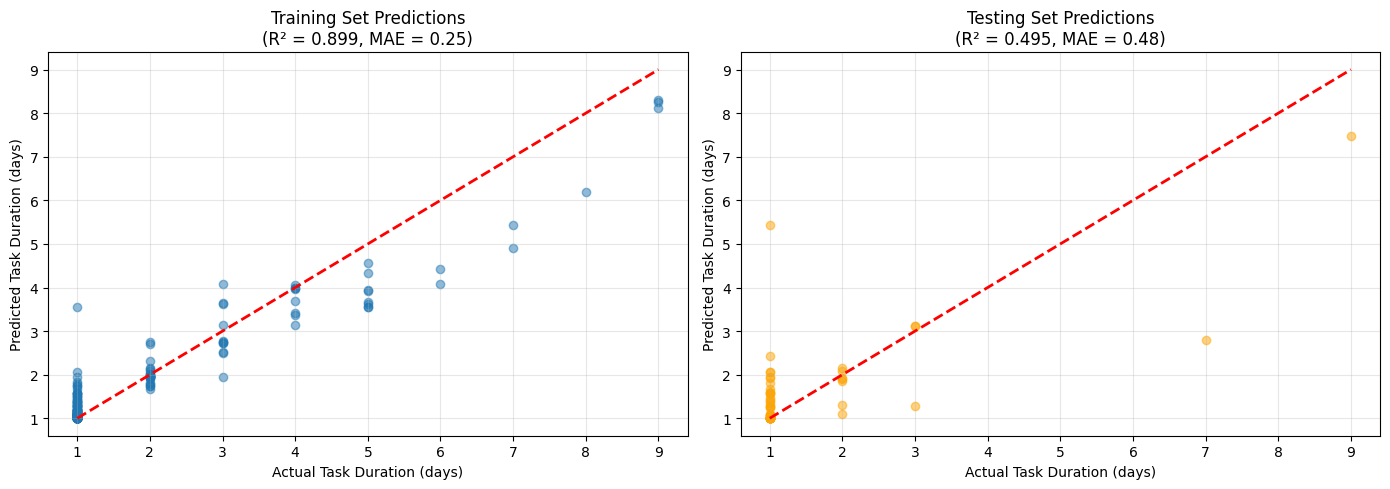

In [17]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Task Duration (days)')
axes[0].set_ylabel('Predicted Task Duration (days)')
axes[0].set_title(f'Training Set Predictions\n(R² = {train_r2:.3f}, MAE = {train_mae:.2f})')
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Task Duration (days)')
axes[1].set_ylabel('Predicted Task Duration (days)')
axes[1].set_title(f'Testing Set Predictions\n(R² = {test_r2:.3f}, MAE = {test_mae:.2f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8. Feature Importance Analysis

Feature Importance (All Features):
              feature  importance
2             Variant    0.215883
0           task_name    0.215842
6          task_count    0.191544
3            Operator    0.181823
4  Intervention level    0.066787
5                  By    0.065859
1              Engine    0.062262


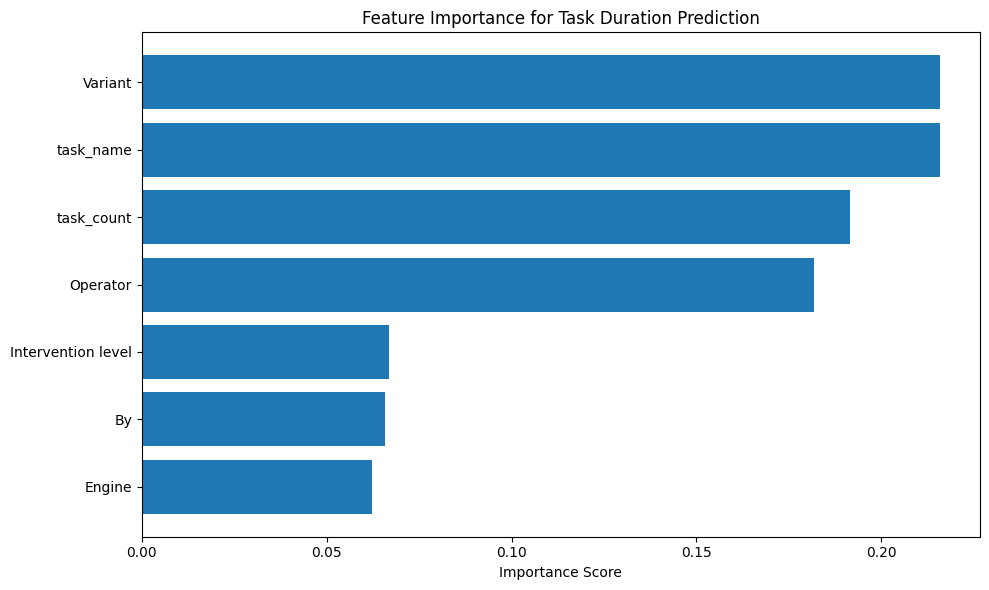

In [18]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (All Features):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for Task Duration Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 9. Example Predictions for Common Tasks

In [19]:
# Get predictions for each unique task in the test set
test_results = pd.DataFrame({
    'task_name_encoded': X_test['task_name'],
    'actual_duration': y_test,
    'predicted_duration': y_test_pred
})

# Decode task names
if 'task_name' in label_encoders:
    test_results['task_name'] = label_encoders['task_name'].inverse_transform(test_results['task_name_encoded'])
    
    # Group by task and show average actual vs predicted duration
    task_comparison = test_results.groupby('task_name').agg({
        'actual_duration': 'mean',
        'predicted_duration': 'mean'
    }).round(2).sort_values('actual_duration', ascending=False)
    
    task_comparison['error'] = (task_comparison['predicted_duration'] - task_comparison['actual_duration']).abs()
    
    print("\nTask Duration Predictions:")
    print(task_comparison)


Task Duration Predictions:
                                     actual_duration  predicted_duration  \
task_name                                                                  
OVSP DRAIN VALVE                                 9.0                7.48   
MO3 REPLACEMENT                                  7.0                2.80   
150H INSPECTION                                  3.0                3.12   
500H INSPECTION                                  3.0                3.12   
KANBAN REPORT                                    2.0                1.09   
HMU INSTALLATION                                 2.0                1.91   
STANDARD EXCHANGE 02                             2.0                1.92   
STANDARD EXCHANGE MO1                            2.0                2.08   
MO4 REPLACEMENT                                  1.5                1.63   
PIR                                              1.4                1.63   
APPLICATION TU 81 DECU SN 929                    1.0        